# Нейронные сети классификации изображений


# 2 Сеть VGG
Сеть AlexNet по современным меркам довольно простая и не очень глубокая. Наблюдается тенденция увеличения количества слоев в нейронных сетях, что влечет за собой трудности создания и обучения таких сетей.

Для разработки очень неудобно, когда все слои разные, ведь надо думать о каждом их них. Дом гораздо проще строить из готовых блоков, чем думать о форме каждого кирпичика. Так же и с сетями, когда они становятся большими, задумываться детально о каждом слое становится затруднительно.

Так будем строить сети из блоков слоев! Договоримся, какие блоки будем использовать и будем наращивать размер сети добавлением блоков, одинаковых (или очень похожих) по своей архитектуре. Получим блочно-последовательную архитектуру. Регулярность блоков существенно упрощает их реализацию, как программную, так и аппаратную.

Такая идея реализована в сетях VGG [Visual Geometry Group](http://www.robots.ox.ac.uk/~vgg/) (VGG)

## Ядра сверток
Необходимо договориться, какие именно ядра сверток использовать. С одной стороны, малые ядра дают маленькое поле восприятия, большие же - большое. Но с другой стороны малые ядра проще считать, большие - сложней.

На помощь приходит тот факт, что использование нескольких сверток с малым ядром эквивалентно (по крайней мере по величине окна восприятия) одной свертке с большим ядром. Так что из набора сверток с малым ядром вполне успешно можно создавать архитектуры, которые изначально работали со свертками с большим ядром. Их и положим в основу блоков.

На рис. показана эквивалентность одной свертки с ядром 5 на 5 (поле восприятия также 5 на 5) и *двух* подряд сверток с ядром 3 на 3, которые дают совокупное поле восприятия 5 на 5. Но сравните их размер: ядро 5 на 5 содержит 25+1 параметров, а два ядра 3 на 3 содержат 9+9+1+1=20 параметров.  

![img](https://www.jeremyjordan.me/content/images/2018/04/Screen-Shot-2018-04-17-at-5.32.45-PM.png)


## Блоки слоев VGG
Для сверточных сетей обычно блоки выглядят так:
1. Сверточный слой с набивкой,
2. Нелиненая активация (например, ReLU)
3. Субдискретизация (например,maxpooling)

В блоках VGG решили что он будет состоять из
1. *Набор* сверточных слоев с ядром 3 на 3, набивкой и активацией ReLU. Количество сверточных слоев задается.
2. Субдискретизация maxpooling с ядром 2 на  2 и сдвигом 2.


Давайте реализуем создание таких блоков в функции  `vgg_block`.

Эта функция принимает два аргумента:
- `num_convs` - число сверточных слоев в блоке,
- `num_channels` - число каналов выхода (число фильтров).


In [1]:
# установим вспомогательные функции из курса  d2l
!pip -q install d2l==0.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from d2l import tensorflow as d2l # вспомогательные функции для данных, обучения и отображения

# Создание блока VGG
def vgg_block(num_convs, num_channels): # число сверток и число фильтров
    blk = tf.keras.models.Sequential() # последовательный контейнер
    for _ in range(num_convs): # в цикле по количеству сверточных слоев
        blk.add(tf.keras.layers.Conv2D(num_channels,kernel_size=3,
                                    padding='same',activation='relu')) # добавляем сверточный слой, ядро 3 на 3, набивка, активация
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2)) # в конце блока добавляем субдискретизацию
    return blk # возвращаем блок

## Сеть VGG

Как и  AlexNet сеть VGG состоит из набора сверточных слоев, завершающихся полносвязными слоями и слоем классификации.

![img](https://d2l.ai/_images/vgg.svg)


Зададим переменную `conv_arch`, которая будет определять архитектуру сверточной части сети, список кортежей из двух аргументов для каждого блока:
- число сверточных слоев блока,
- число фильтров (каналов).

Полносвязная часть будет такой же как у AlexNet.

Оригинальная VGG-11 имела 5 блоков, первые два с одним сверточным слоем, следующие три с двумя сверточными слоями. 8 сверточных и 3 полносвязных дали название этой сети.
Количество фильтров начиная с 64 для первого слоя удваивалось, пока не достигало 512.

Сегодня есть модификации гораздо более глубокие, с большим числом блоков.

Мы же сделаем небольшую VGG-подобную сеть.


In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [4]:
# Задаем сеть VGG
def vgg(conv_arch): # принимаем описание блоков сверточной части
    net = tf.keras.models.Sequential() # последовательный контейнер
    # Сверточная часть
    for (num_convs, num_channels) in conv_arch: # в цикле по количеству блоков
        net.add(vgg_block(num_convs, num_channels)) # добавляем блок с заданными параметрами
    # Полносвязная часть
    net.add(tf.keras.models.Sequential([
        tf.keras.layers.Flatten(), # выпрямитель
        tf.keras.layers.Dense(4096, activation='relu'), # полносвязный
        tf.keras.layers.Dropout(0.5), #
        tf.keras.layers.Dense(4096, activation='relu'), # полносвязный
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10)])) # полносвязный слой классификации по числу классов
    return net # возвращаем сеть

net = vgg(conv_arch) # создаем сеть

Проверим размерности выходов всех блоков. Первое измерение - примеры. Посчитайте эти размерности самостоятельно, затем объясните вывод. Хм, а куда подевались другие слои? Найдите их самостоятельно.


In [5]:
X = tf.random.uniform((1, 224, 224, 3))
for blk in net.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Sequential output shape:	 (1, 10)


Обучим сеть нашей задаче, но упростим ее, уменьшим число каналов, ведь она слишком большая для малоразмерных изображений.


In [6]:
ratio = 4 # сокращаем в 4 раза
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch] # новая архитектура
net = lambda: vgg(small_conv_arch) # создаем.


In [7]:
input_shape=(None,224, 224, 3)
nn=net()
nn.build(input_shape)
nn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 112, 112, 16)      448       
                                                                 
 sequential_9 (Sequential)   (None, 56, 56, 32)        4640      
                                                                 
 sequential_10 (Sequential)  (None, 28, 28, 64)        55424     
                                                                 
 sequential_11 (Sequential)  (None, 14, 14, 128)       221440    
                                                                 
 sequential_12 (Sequential)  (None, 7, 7, 128)         295168    
                                                                 
 sequential_13 (Sequential)  (None, 10)                42516490  
                                                                 
Total params: 43093610 (164.39 MB)
Trainable params: 4

*должна быть представлена в виде функции, чтобы можно было в `d2l.train_ch6()` использовать GPU.*

Обучаем ~ 20-25 минут.


loss 0.172, train acc 0.936, test acc 0.914
920.0 examples/sec on /GPU:0
CPU times: user 14min 9s, sys: 46.7 s, total: 14min 55s
Wall time: 12min 7s


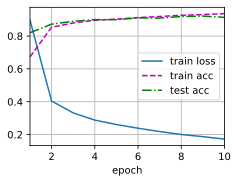

In [ ]:
%%time
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

Сравните размеры, время обучения и аккуратность AlexNet и VGG.

# Ссылки
Использованы и адаптированы материалы

https://d2l.ai/chapter_convolutional-modern/vgg.html#